# Word2Vec Implementation and Application

#### Contents:

**Implementation Section**

- Implement Word2Vec using the Gensim library in Python.
- Train Word2Vec on the dataset and experiment with different hyperparameters (eight different models included).
- Look at the similarity between the words "dress" and "shoes" for each model.
- Look at most similar words to "shoes" for each model.
- Visualize the learned word embeddings using dimensionality reduction (T-SNE).

**Applications Section**

- Word2Vec for sentiment analysis, with classification use-case to assess the performance of the embeddings.
- Comparison of Word2Vec with a baseline TF-IDF model for sentiment analysis.
- Comparison of Word2Vec with Doc2Vec for sentiment analysis.

**Conclusion Section**

- Strengths and weaknesses of Word2Vec.
- Challenges with this implementation / application.
- Additional notes on the results and the sentiment analysis task.

# Implementation Section:

### Data Description:

This dataset is from Kaggle and contains ~22.6k reviews from Amazon for clothing.

### Word2Vec Configurations and Hyperparameters:

* `vector_size`: Dimensionality of the word vectors. We increase from the default size of `100` to 300 to learn more complex relationships between words.
* `window`: Maximum distance between the current and predicted word within a sentence. We increase the window size from `5` to `15` to capture more context.
* `min_count`: Ignores all words with a total frequency lower than this. We set the minimum count to `5` to ignore words with very low frequency.
* `workers`: Use these many worker threads to train the model. We set the number of workers to `10` to utilize the ten cores on our machine.
* `epochs`: Number of iterations (epochs) over the corpus. We play with different epoch values to see how it affects the embeddings.
* `sg`: Training algorithm: 1 for skip-gram; 0 for CBOW. We experiment with both algorithms to see which one performs better.
* `hs`: If 1, hierarchical softmax will be used for model training. If 0, and `negative` is non-zero, negative sampling will be used. We experiment with hierarchical softmax and negative sampling.

**We trained eight different Word2Vec models with different hyperparameters and compared the similarity between the words "dress" and "shoes" for each model. We also look at the T-SNE visualization for a review to see how the words are clustered in the 2D space.**

In [16]:
# Importing the necessary libraries for the implementation
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
import matplotlib.pyplot as plt
import numpy as np  
from os.path import expanduser
import pandas as pd
from sklearn.manifold import TSNE

# Importing the necessary libraries for the application
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from yellowbrick.classifier import ROCAUC
from sklearn.preprocessing import LabelEncoder
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
path = expanduser('~/data/Women Dresses Reviews Dataset .csv')
data = pd.read_csv(path, usecols=["review_text", "rating"])
data.dropna(inplace=True)

In [18]:
docs = data.review_text.tolist()

In [19]:
# Preprocessing with GenSim's simple_preprocess
docs = [simple_preprocess(doc) for doc in docs]

In [20]:
# T-SNE visualization
def tsne_plot(model_obj, review, title="T-SNE Visualization"):
    """
    Takes a Word2Vec model and a review, and visualizes the word embeddings.
    for a given review in the context of the entire vocabulary.
    A visualization is created with each unique word in the review plotted in the 2D space, using T-SNE
    for dimensionality reduction.
    
    :param model_obj: Word2Vec model object
    :param review: A list of words from a review
    :param title: Title of the plot
    :return: None
    """
    # Remove stopwords
    review = [remove_stopwords(_) for _ in review]

    labels = []
    wordvecs = []
    
    for word in set(review):
        if word in model_obj.wv.key_to_index:
            wordvecs.append(model_obj.wv[word])
            labels.append(word)

    tsne_model = TSNE(perplexity=2, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(wordvecs))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    
    plt.title(title)
    plt.tight_layout()


In [21]:
# Set the default Word2Vec parameters
word2vec_args = {
    'vector_size': 300, 
    'window': 15,
    'min_count': 5,
    'workers': 10   
}

In [22]:
# Default model parameters
model_defaults = Word2Vec(docs)
model_defaults.train(docs, total_examples=len(docs), epochs=model_defaults.epochs)

(4279290, 6183600)

In [23]:
# Default model with skip-gram instead of CBOW
model_with_sg = Word2Vec(docs)
model_with_sg.train(docs, total_examples=len(docs), epochs=model_with_sg.epochs)

(4279883, 6183600)

In [24]:
# Model with tuned hyperparameters
model_tuned = Word2Vec(sentences=docs, **word2vec_args)
model_tuned.train(docs, total_examples=len(docs), epochs=10)

(8559509, 12367200)

In [25]:
# Model with tuned hyperparameters and skip-gram
model_tuned_sg = Word2Vec(sentences=docs, **word2vec_args, sg=1) # Use skip-gram
model_tuned_sg.train(docs, total_examples=len(docs), epochs=10)

(8559973, 12367200)

In [26]:
# Model with tuned hyperparameters and 20 epochs
model_tuned_20_epochs = Word2Vec(sentences=docs, **word2vec_args)
model_tuned_20_epochs.train(docs, total_examples=len(docs), epochs=20) # Increase epochs to 20

(17122709, 24734400)

In [27]:
# Model with tuned hyperparameters and hierarchical softmax
model_tuned_with_hs = Word2Vec(sentences=docs, **word2vec_args, hs=1) # Use hierarchical softmax
model_tuned_with_hs.train(docs, total_examples=len(docs), epochs=10)

(8560063, 12367200)

In [28]:
# Model with tuned hyperparameters and hierarchical softmax and 20 epochs
model_tuned_with_hs_20_epochs = Word2Vec(sentences=docs, **word2vec_args, hs=1) # Use hierarchical softmax
model_tuned_with_hs_20_epochs.train(docs, total_examples=len(docs), epochs=20) # Increase epochs to 20

(17121571, 24734400)

In [29]:
# Model with tuned hyperparameters and negative sampling 
model_tuned_with_ns = Word2Vec(sentences=docs, **word2vec_args, negative=5) # Use negative sampling
model_tuned_with_ns.train(docs, total_examples=len(docs), epochs=10) # Increase epochs to 20

(8560599, 12367200)

In [30]:
# Dictionary of models for easy access
models = {
    'Default': model_defaults,
    'Skip-Gram': model_with_sg,
    'Tuned': model_tuned,
    'Tuned with Skip-Gram': model_tuned_sg,
    'Tuned with Hierarchical Softmax': model_tuned_with_hs,
    'Tuned with Negative Sampling': model_tuned_with_ns,
    'Tuned with 20 Epochs': model_tuned_20_epochs,
    'Tuned with Hierarchical Softmax and 20 Epochs': model_tuned_with_hs_20_epochs
}

In [31]:
print('Similarity between "dress" and "shoes":')
for name, model in models.items():
    print(f'Model: {name} - score: {model.wv.similarity("dress", "shoes")}')

Similarity between "dress" and "shoes":
Model: Default - score: 0.07138297706842422
Model: Skip-Gram - score: 0.10922792553901672
Model: Tuned - score: 0.1567474752664566
Model: Tuned with Skip-Gram - score: 0.24078278243541718
Model: Tuned with Hierarchical Softmax - score: 0.1884608268737793
Model: Tuned with Negative Sampling - score: 0.15322405099868774
Model: Tuned with 20 Epochs - score: 0.17195823788642883
Model: Tuned with Hierarchical Softmax and 20 Epochs - score: 0.18996775150299072


In [32]:
print('Most similar words to "shoes" for each model:')
for name, model in models.items():
    print('=========')
    print(f'Model: {name}')
    similar_words = model.wv.most_similar('shoes', topn=3)
    for word, score in similar_words:
        print(f"\tWord: {word}, Similarity: {score}")

Most similar words to "shoes" for each model:
Model: Default
	Word: sandal, Similarity: 0.8201888799667358
	Word: accessories, Similarity: 0.7911673784255981
	Word: pumps, Similarity: 0.7789044380187988
Model: Skip-Gram
	Word: pumps, Similarity: 0.8171629905700684
	Word: accessories, Similarity: 0.7841784954071045
	Word: sandal, Similarity: 0.763384222984314
Model: Tuned
	Word: jewelry, Similarity: 0.744485080242157
	Word: wedges, Similarity: 0.727973997592926
	Word: pumps, Similarity: 0.7224693894386292
Model: Tuned with Skip-Gram
	Word: accessories, Similarity: 0.5359505414962769
	Word: jewelry, Similarity: 0.5197300910949707
	Word: tennis, Similarity: 0.5052096247673035
Model: Tuned with Hierarchical Softmax
	Word: heels, Similarity: 0.5019632577896118
	Word: jewelry, Similarity: 0.457542359828949
	Word: accessories, Similarity: 0.4324304759502411
Model: Tuned with Negative Sampling
	Word: wedges, Similarity: 0.7350718975067139
	Word: jewelry, Similarity: 0.710961103439331
	Word: fl

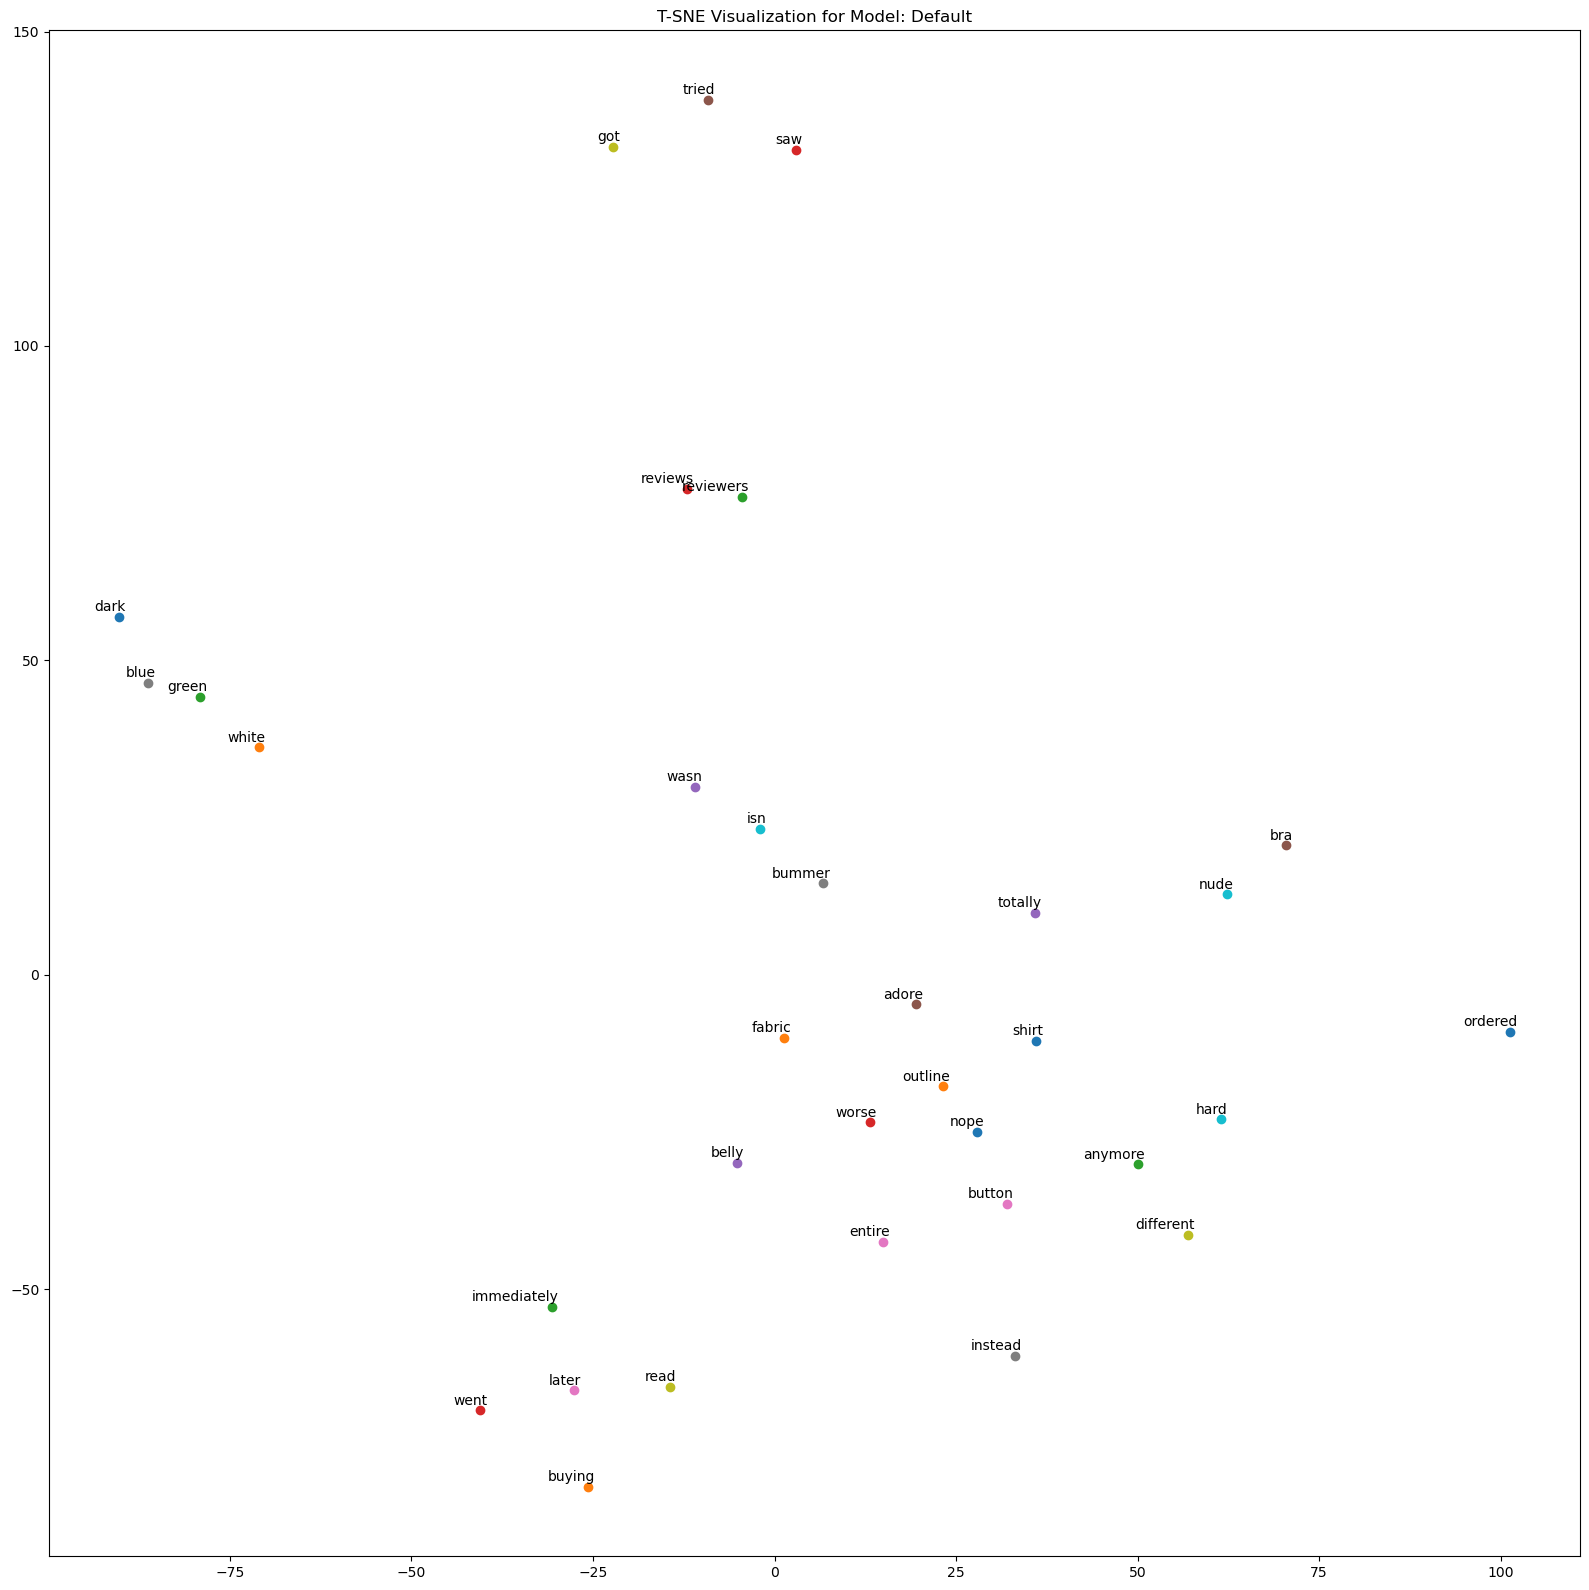

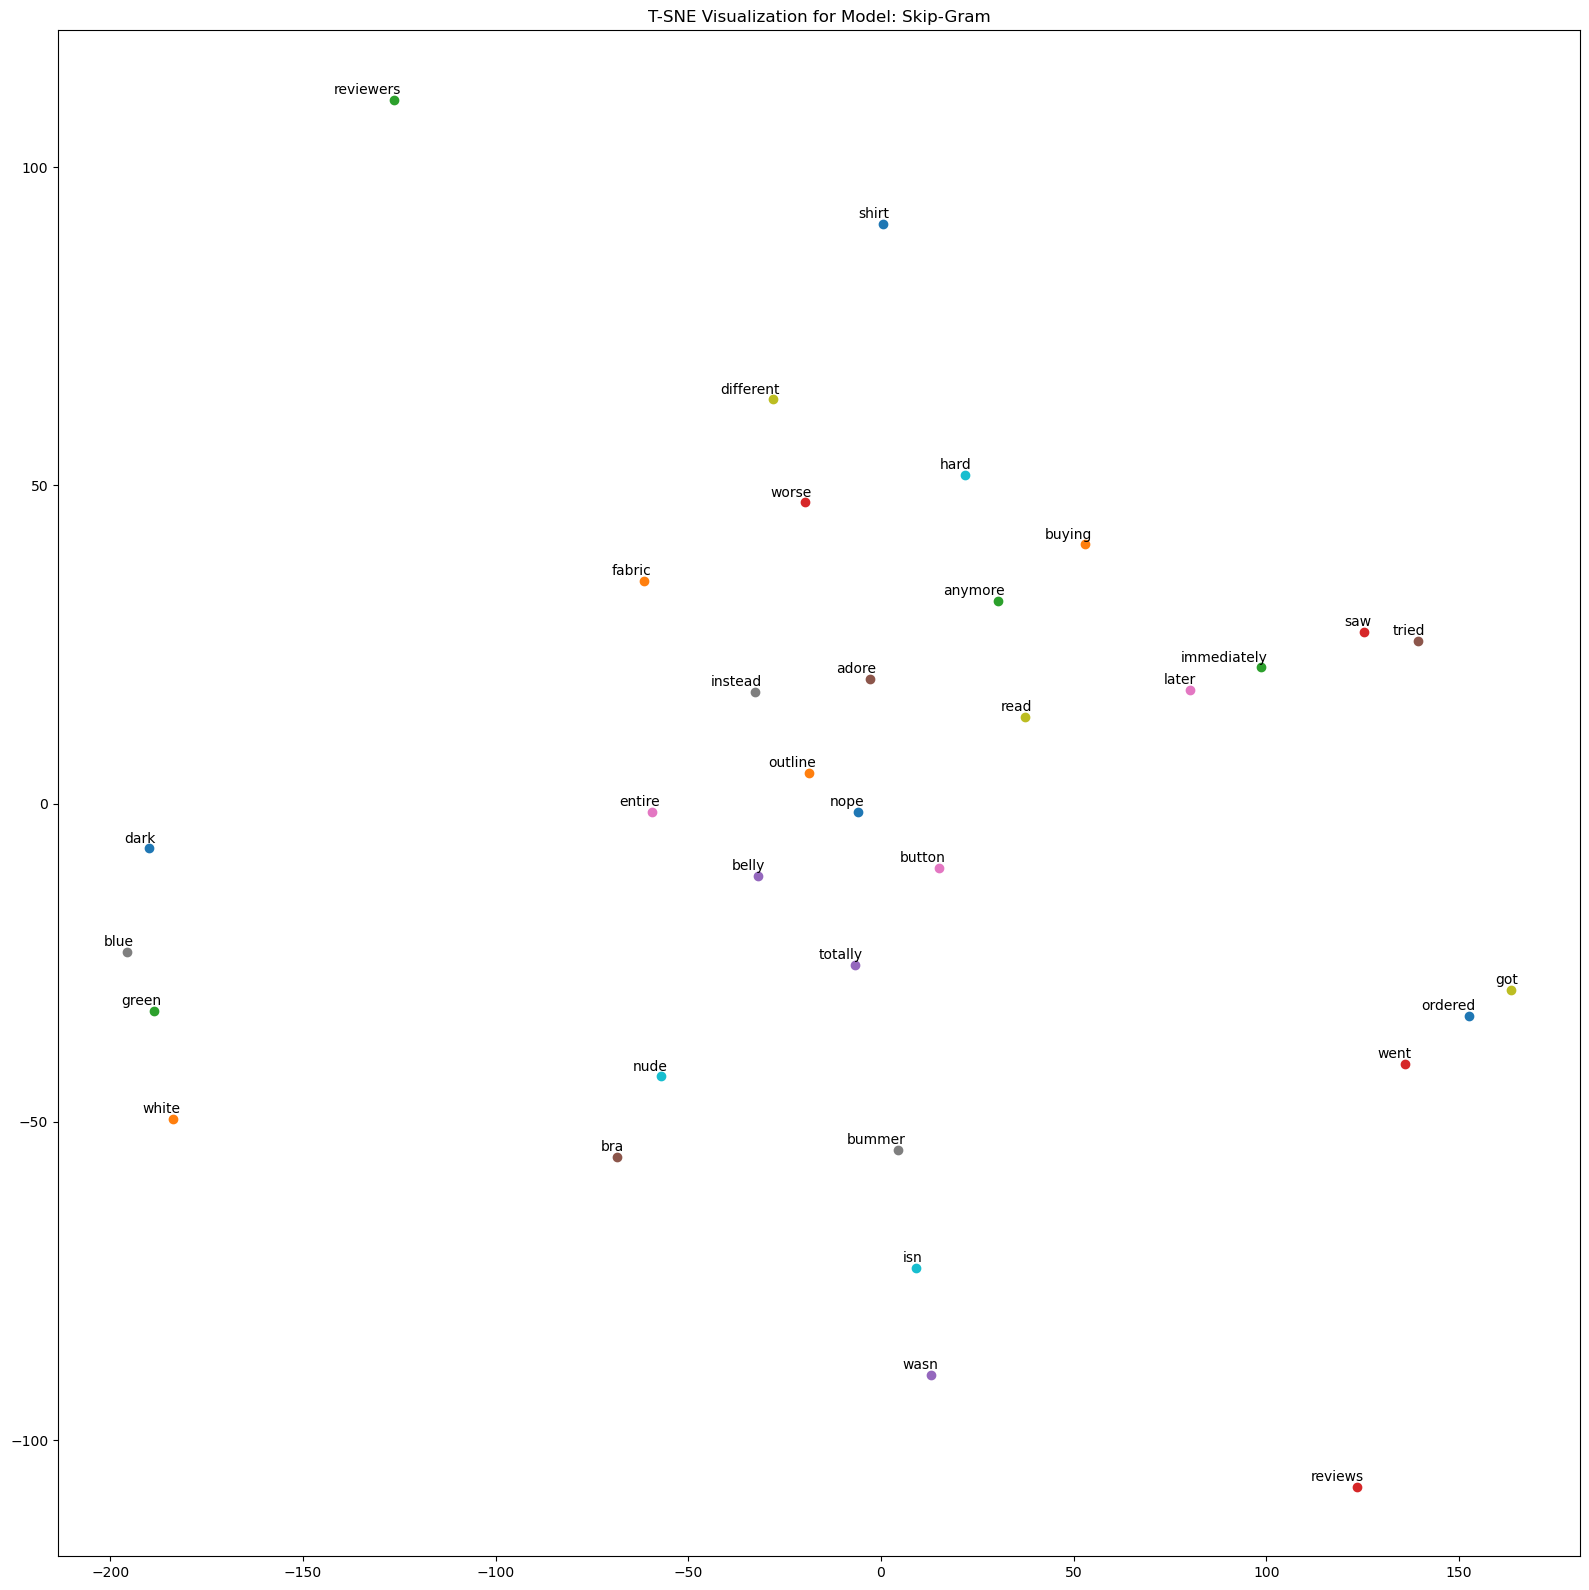

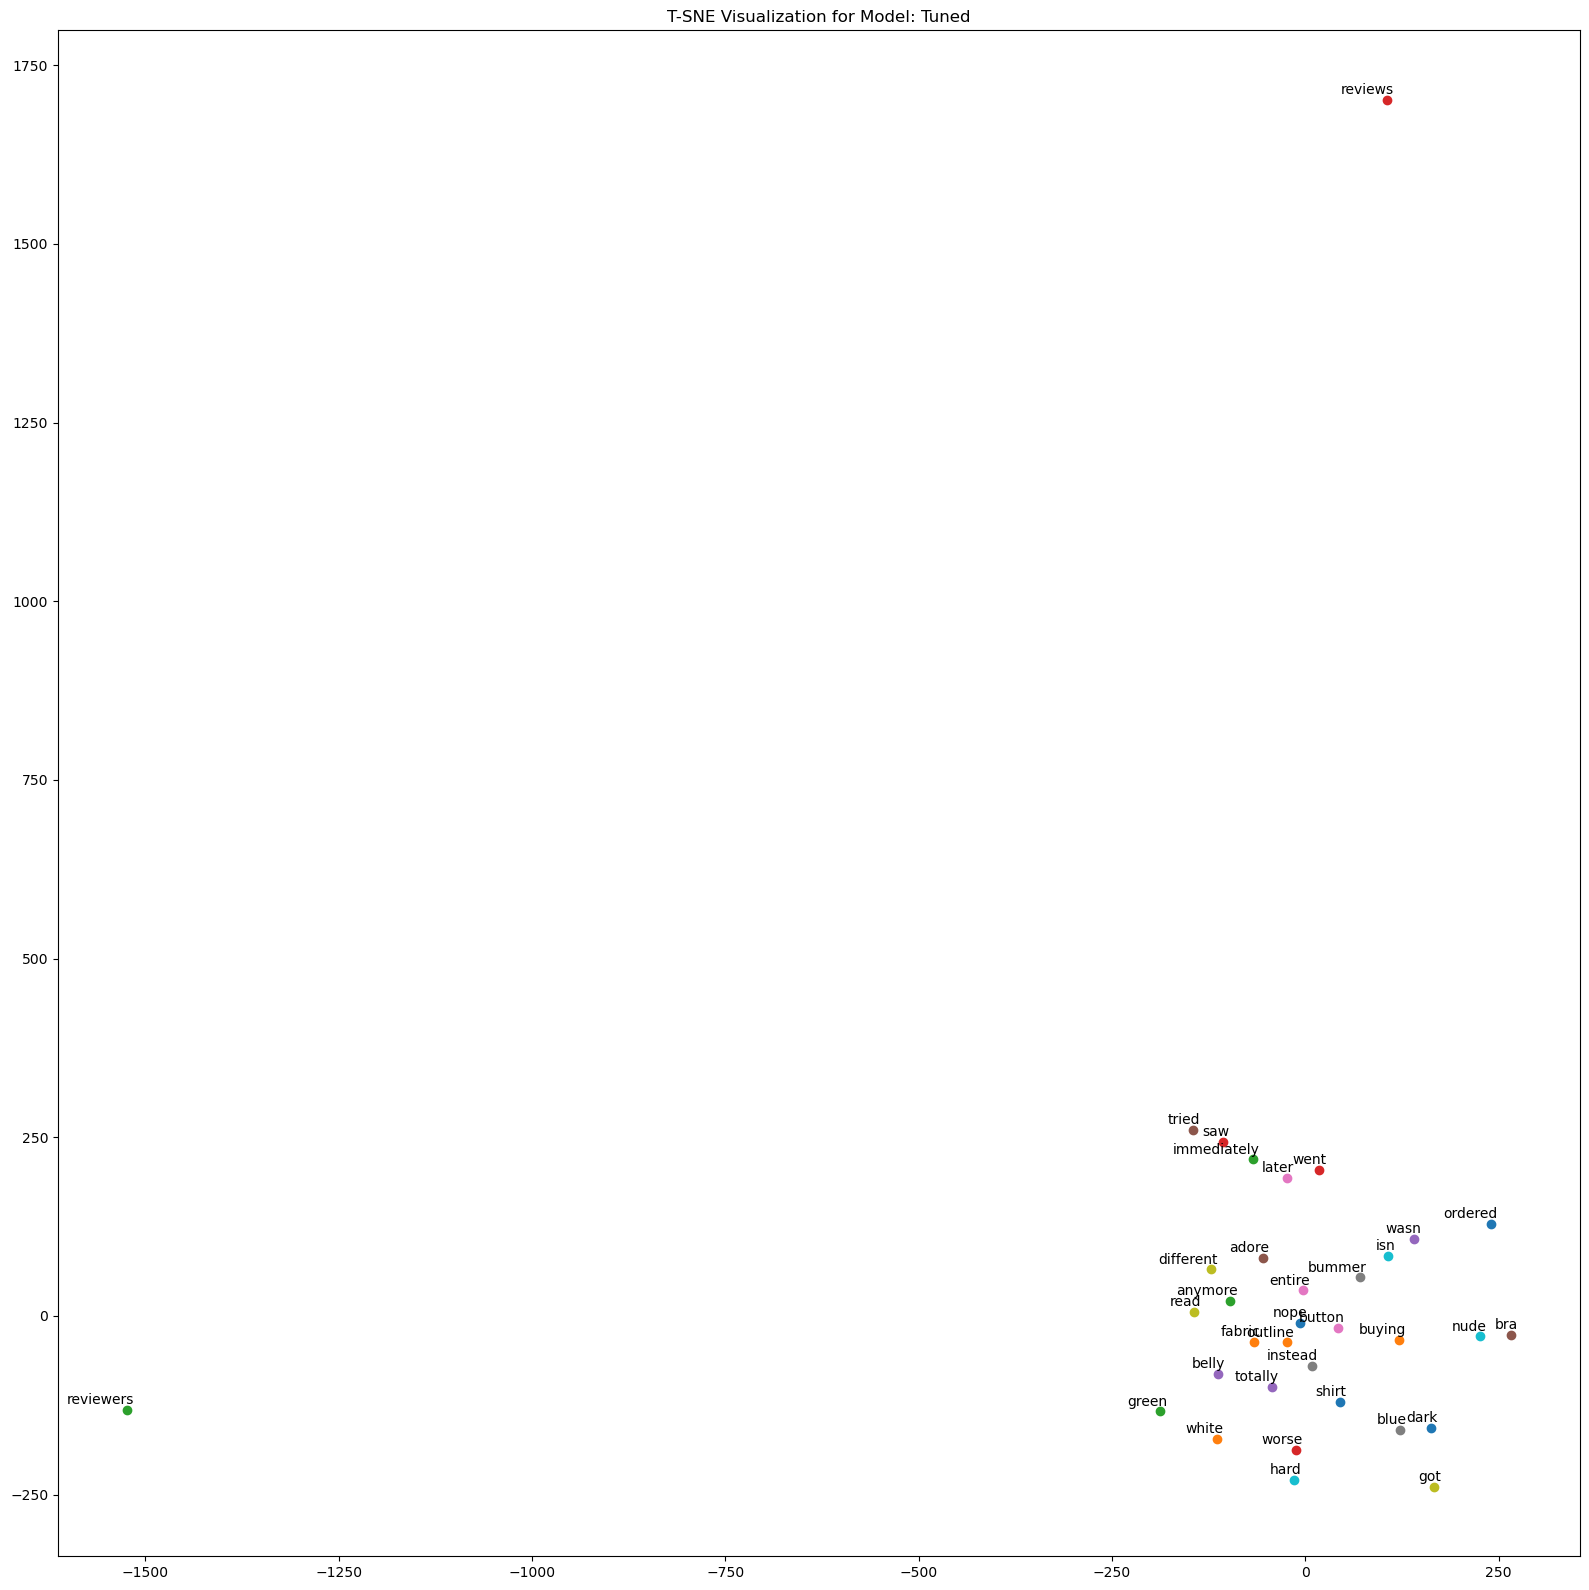

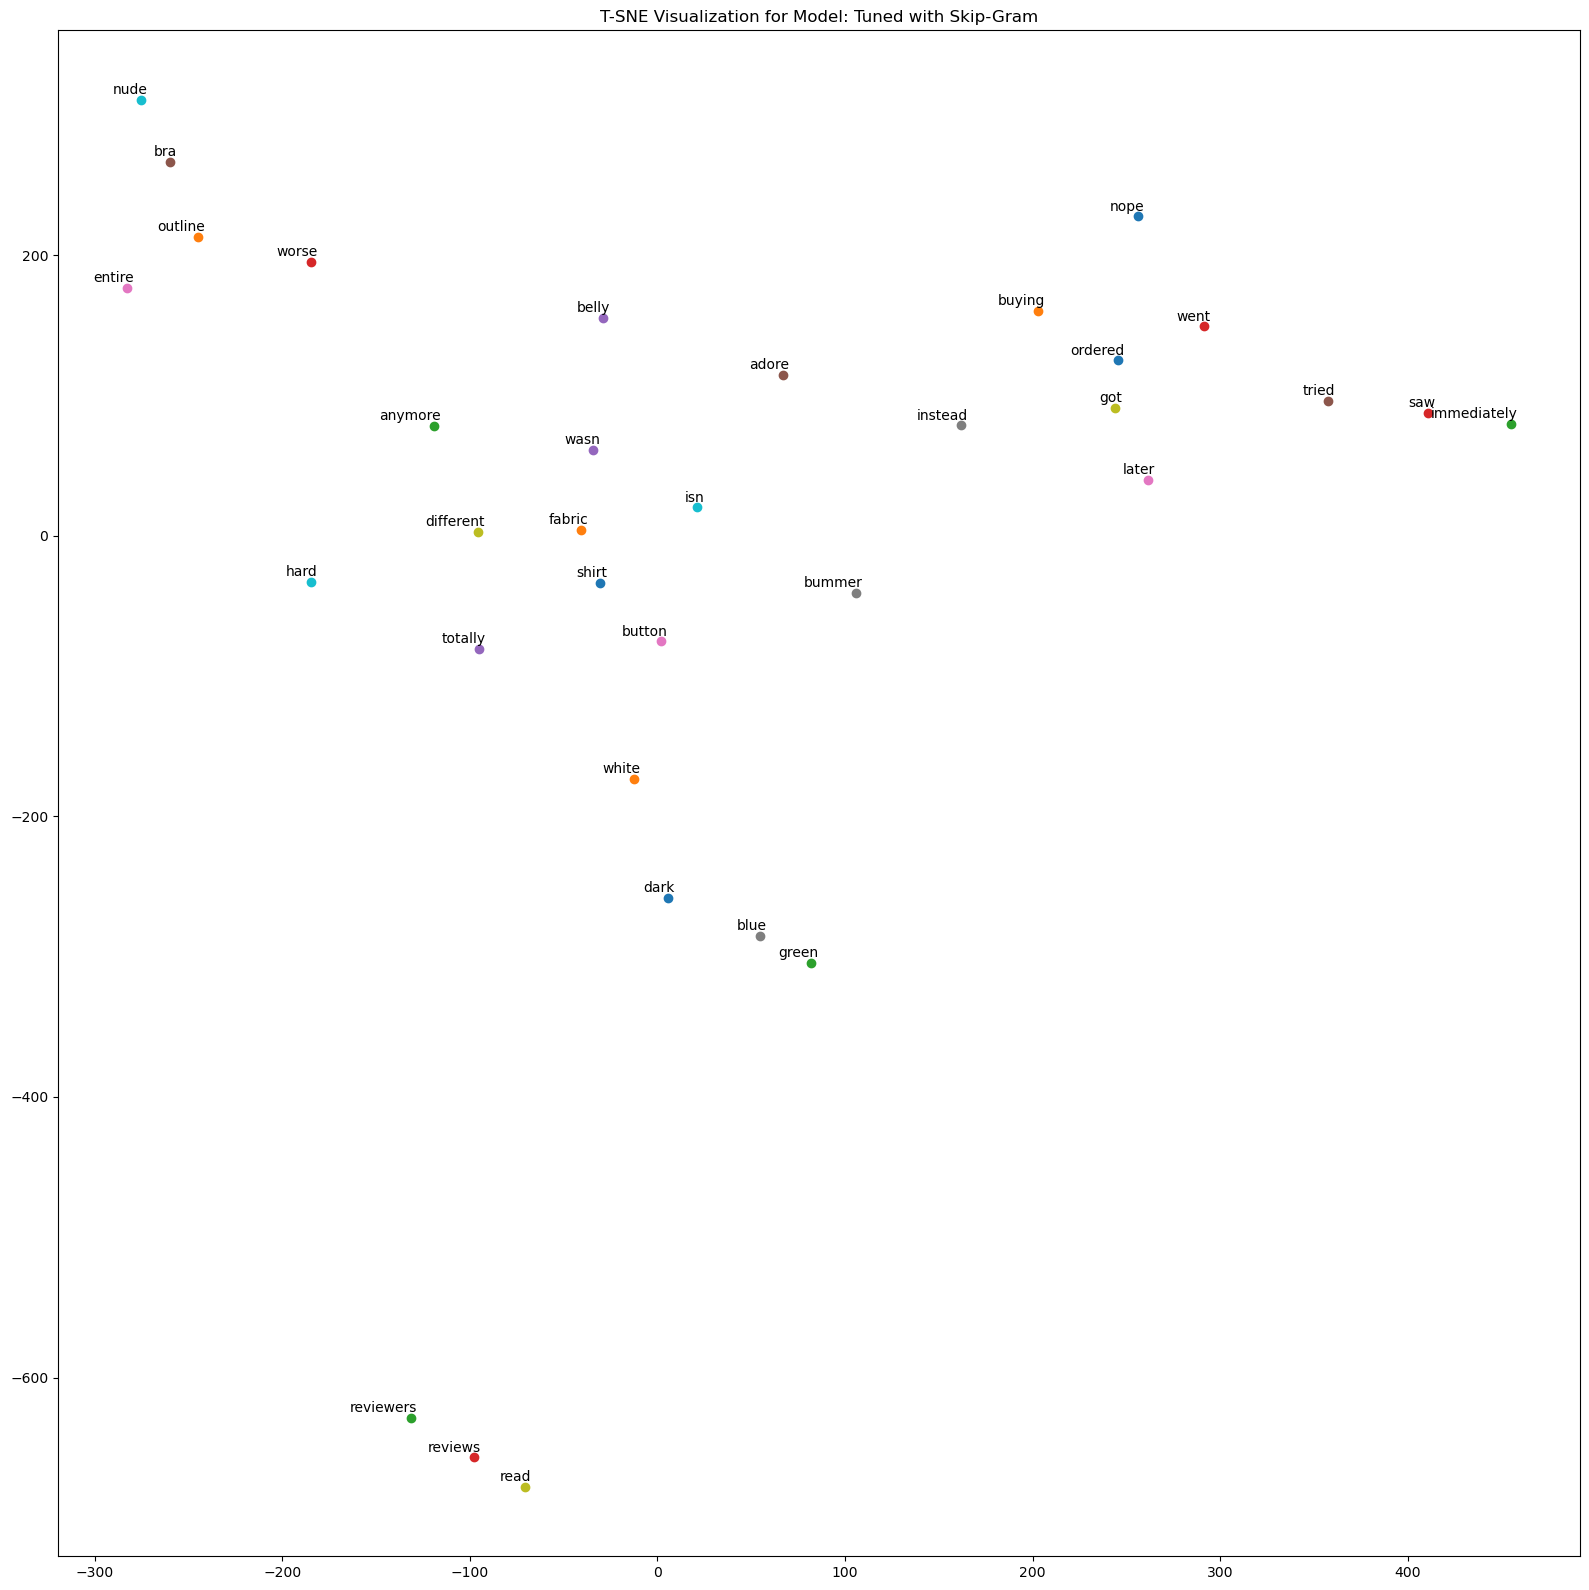

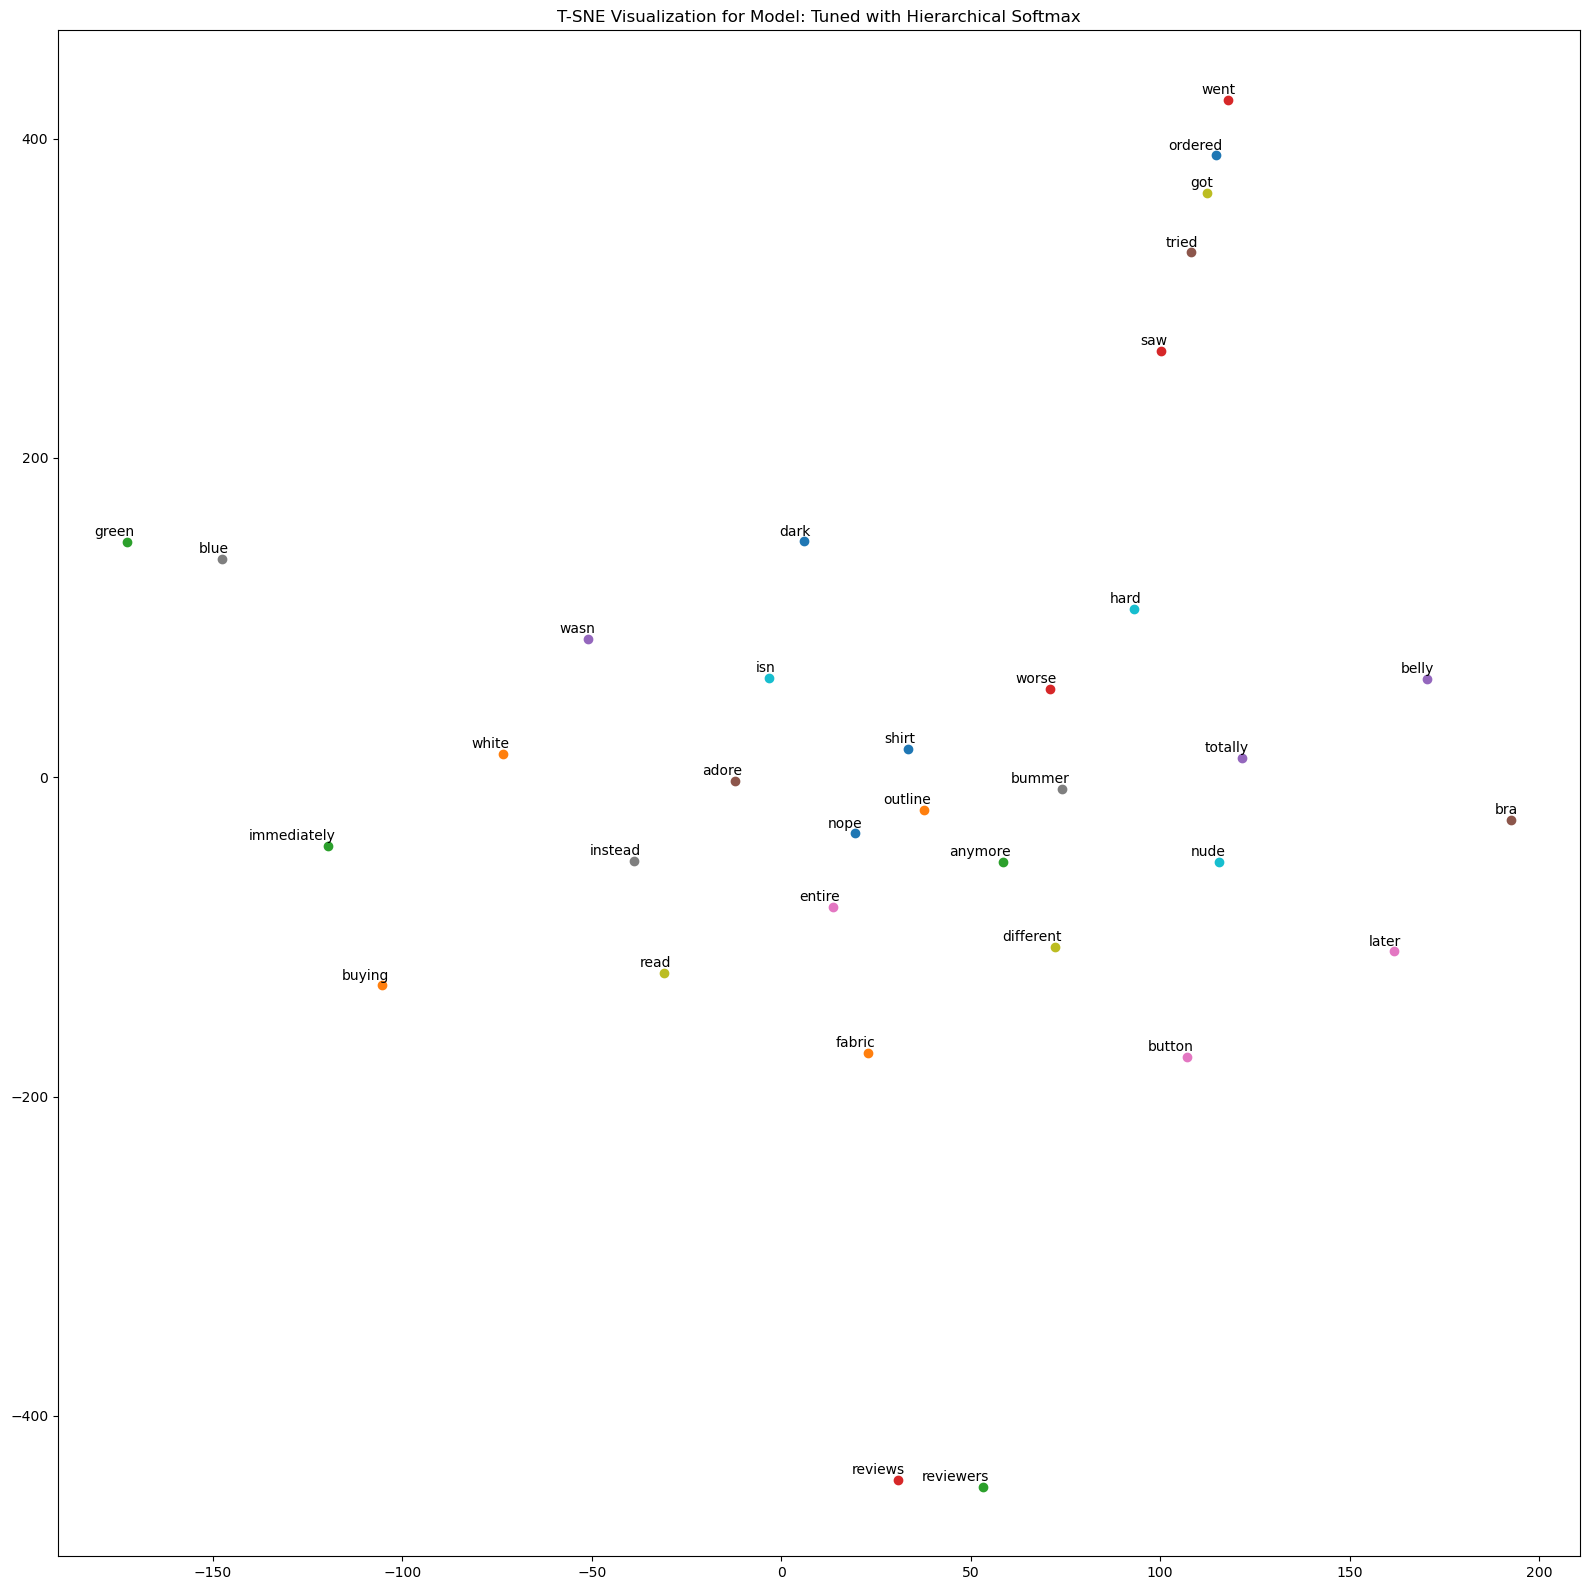

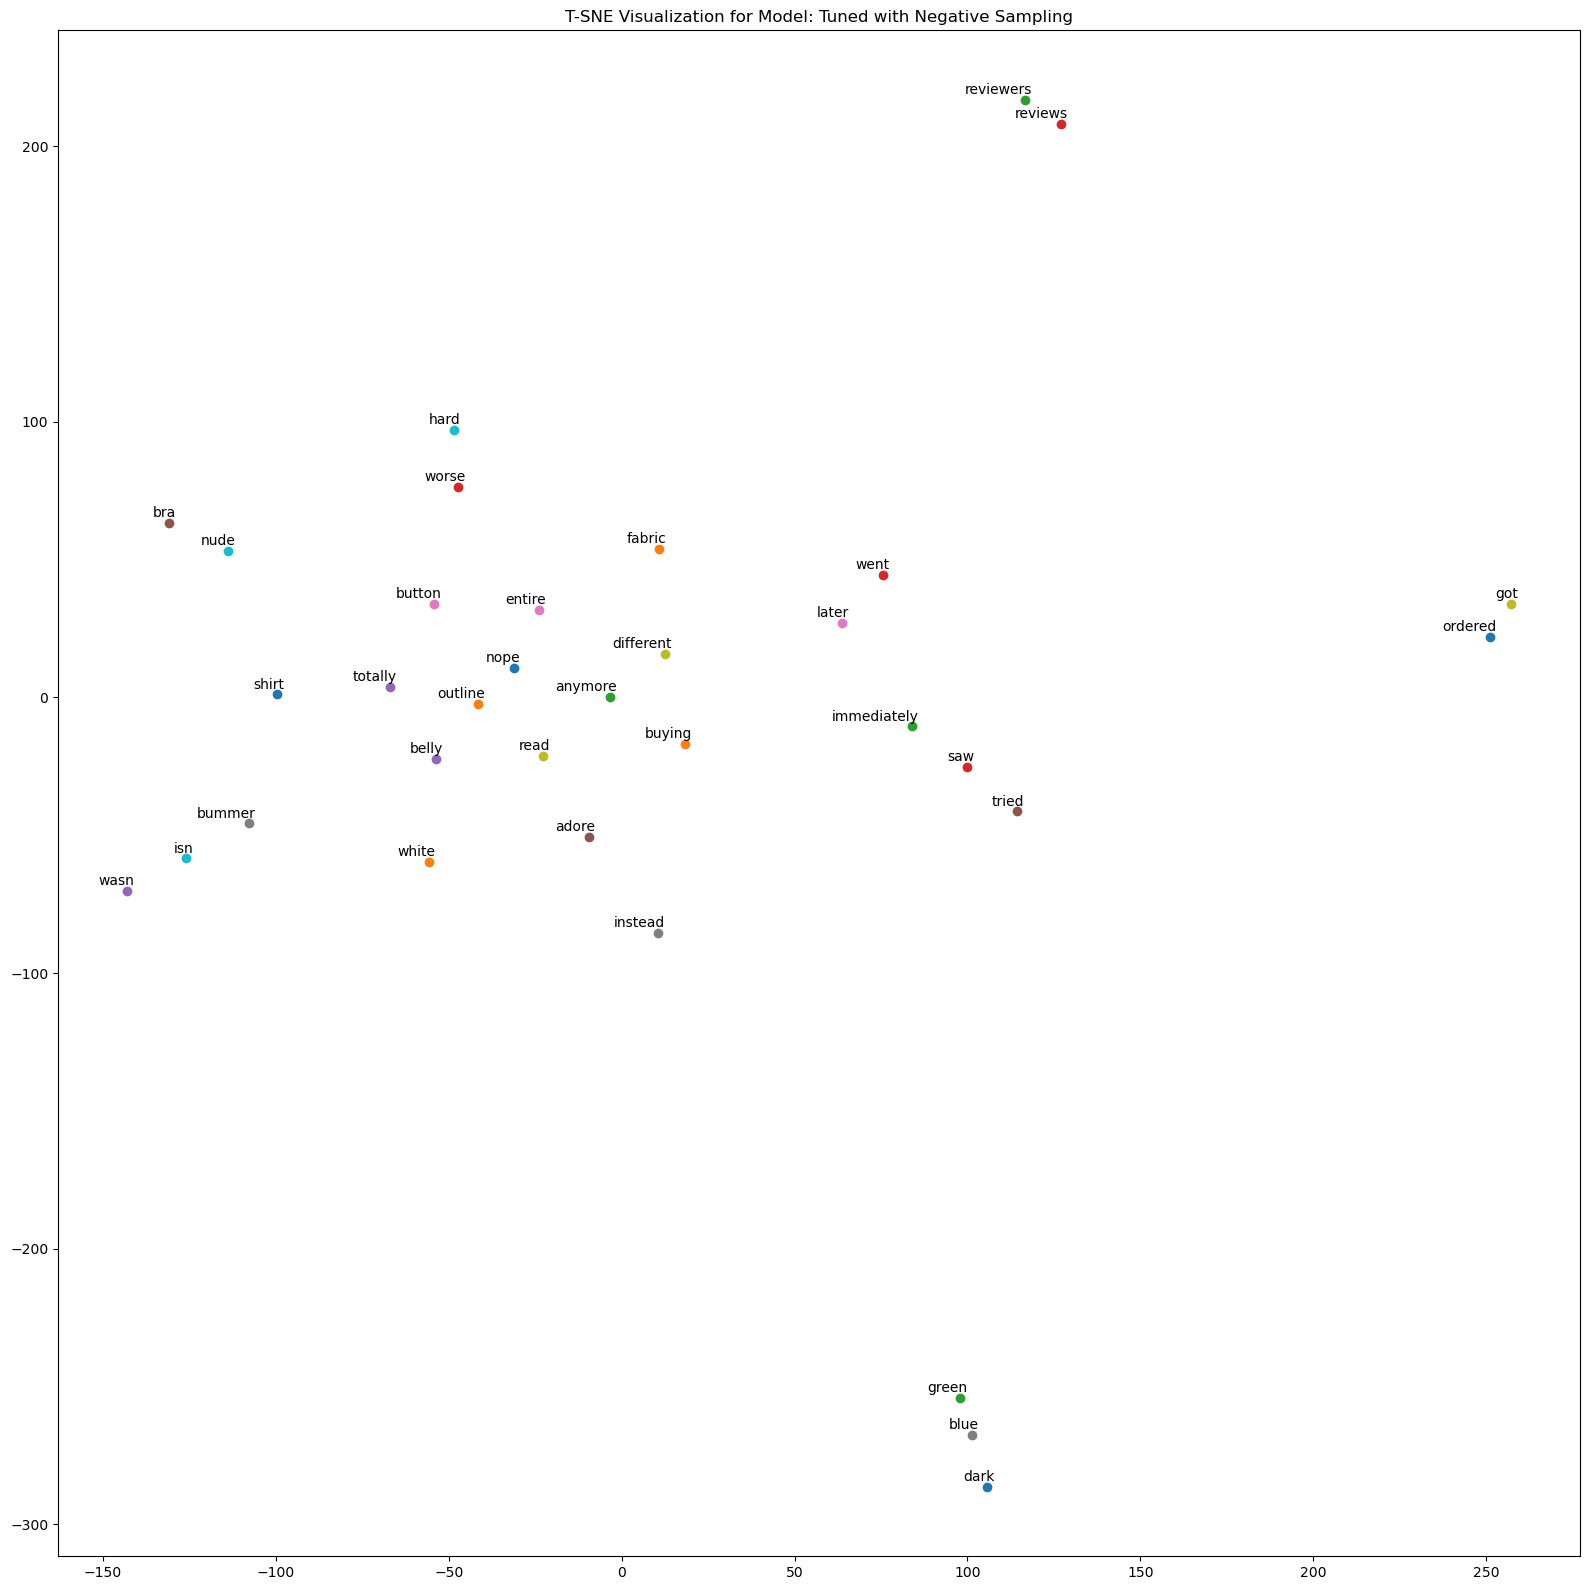

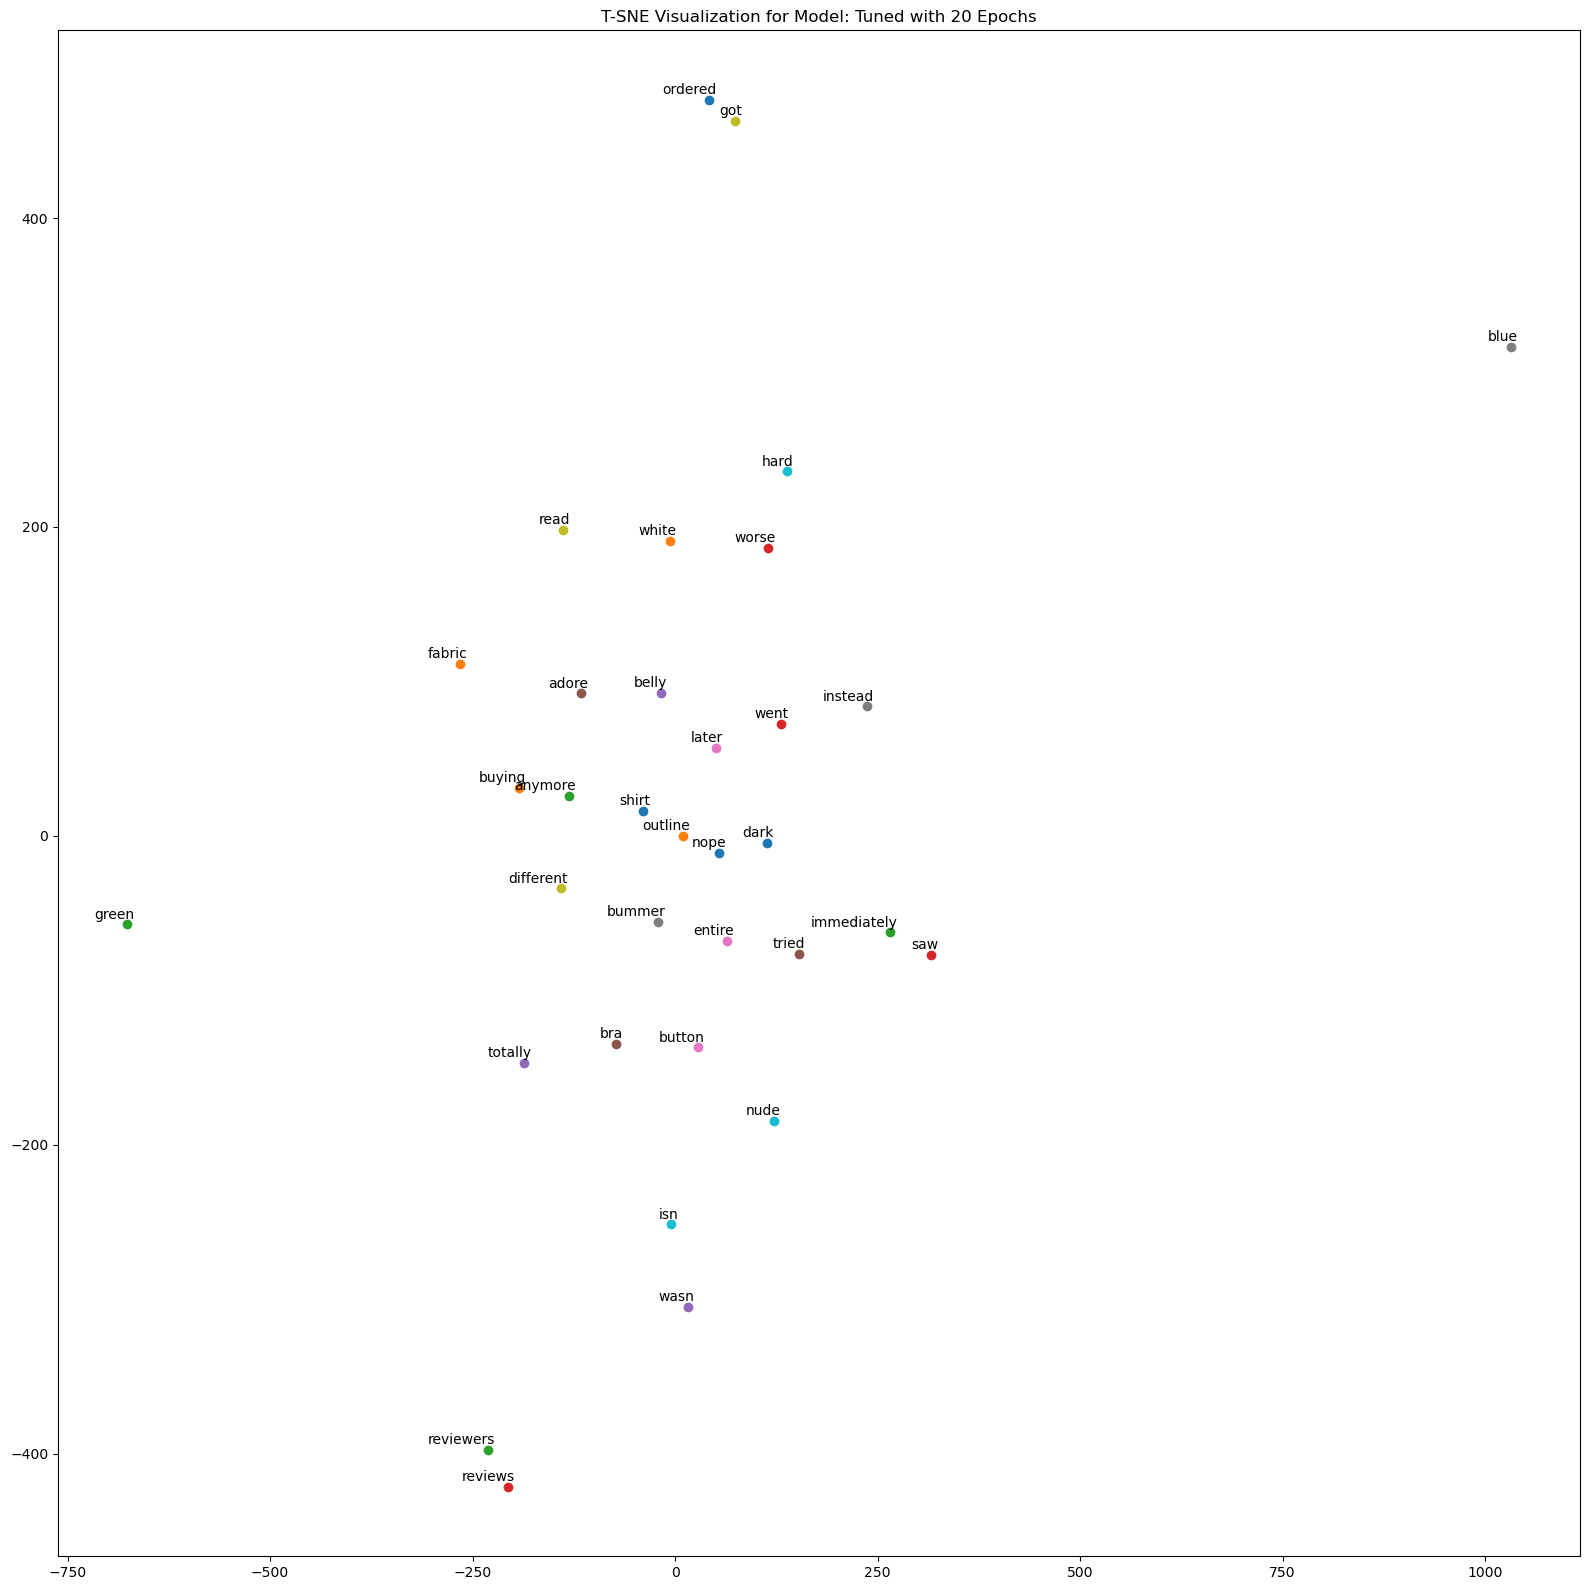

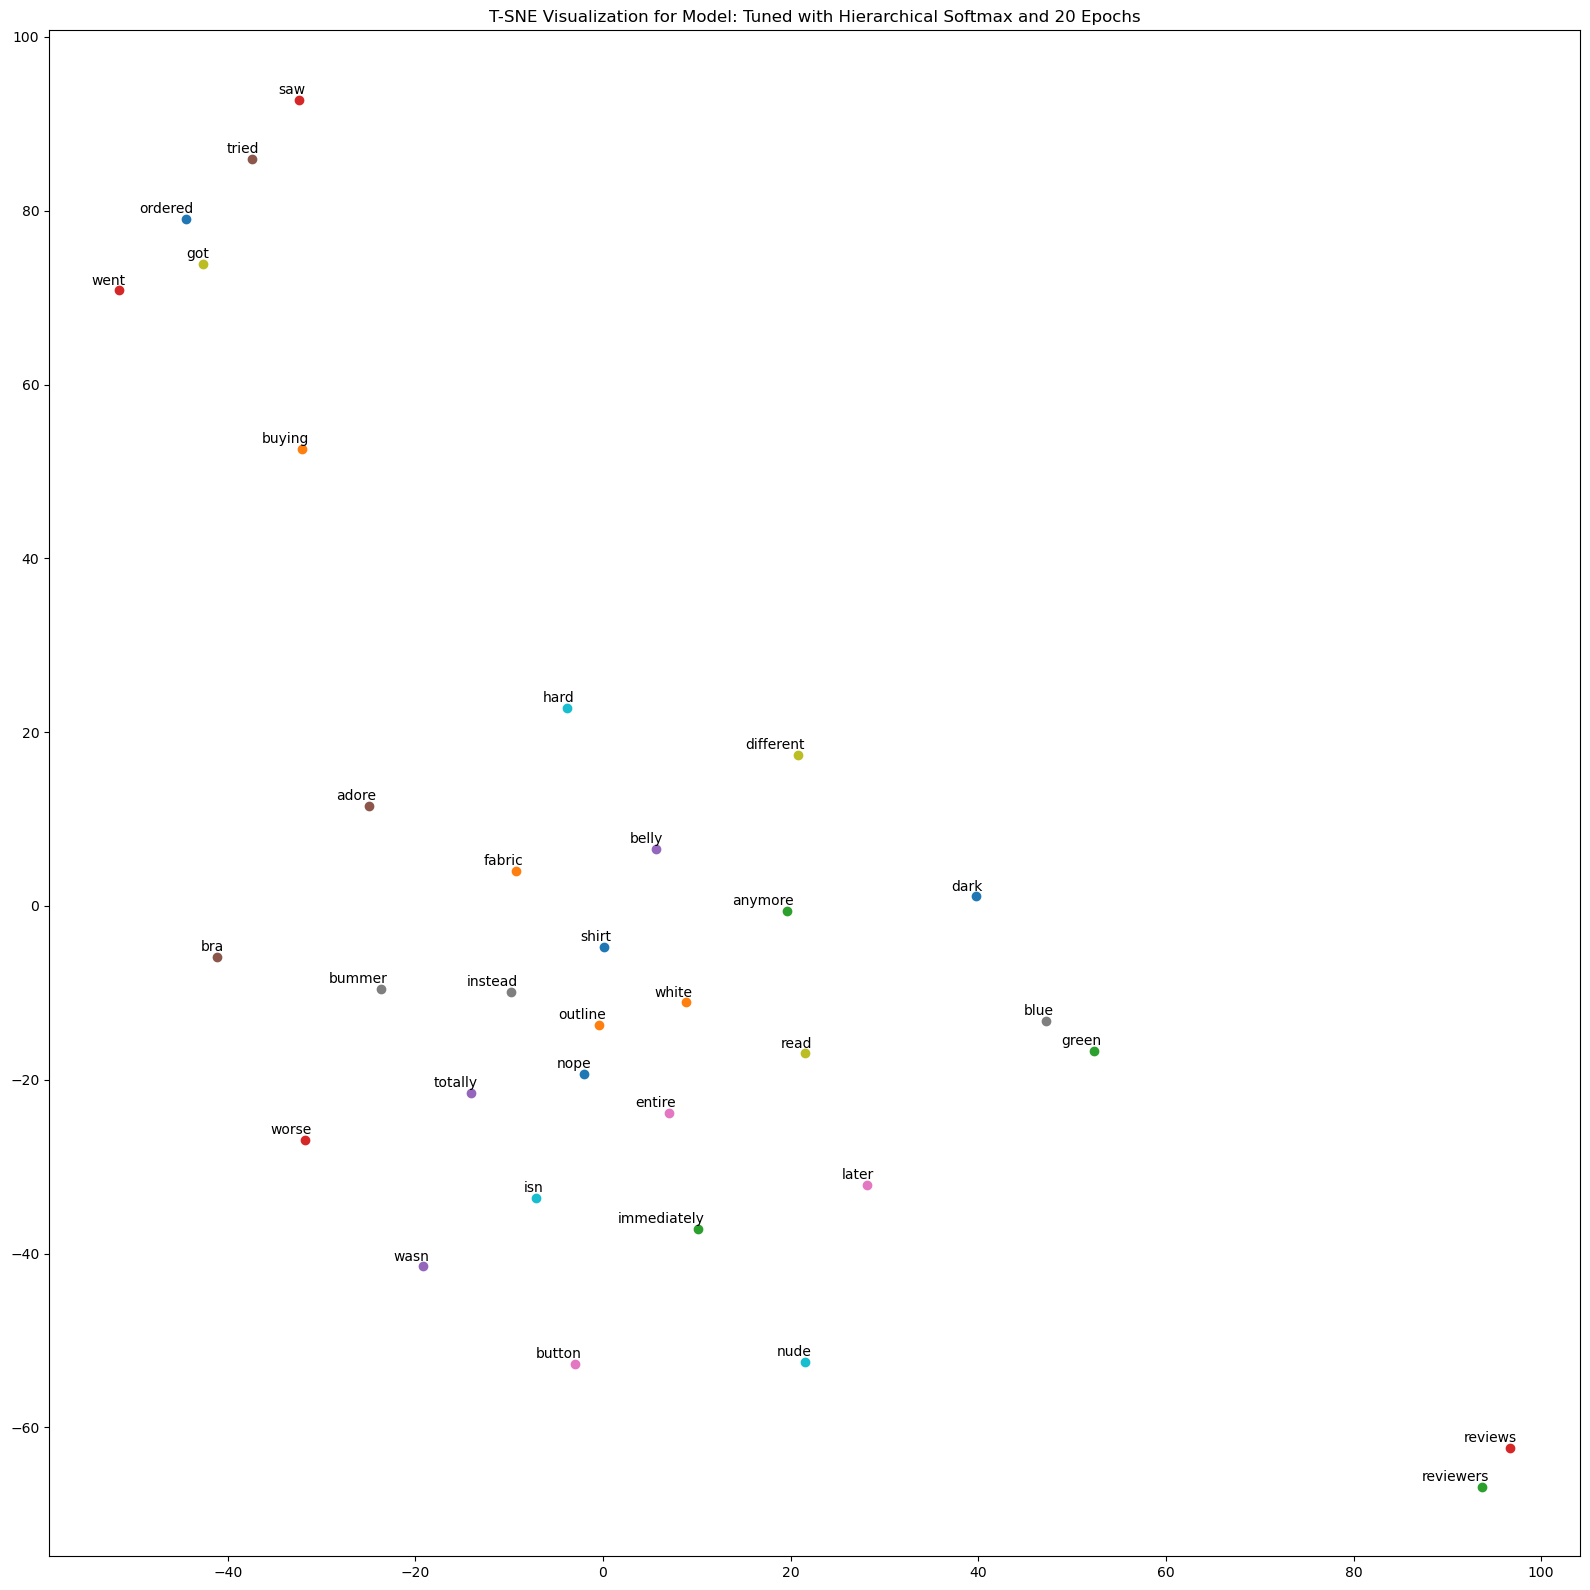

In [33]:
REVIEW_NUM = 11
# Example T-SNE visualization for a given review
# Change `REVIEW_NUM` to see the visualizations for a different review
for name, model in models.items():
    tsne_plot(model, docs[REVIEW_NUM], title=f'T-SNE Visualization for Model: {name}')

# Application Section: Sentiment Analysis

We will use the Amazon reviews dataset to perform sentiment analysis. We will categorize the ratings as positive (1) or negative (0) based on the rating value where ratings greater than 3 are considered positive and ratings less than or equal to 3 are considered negative.
 
We use both a decision tree classifier and a random forest classifier to predict the sentiment category based on the review text. 

We also compare the results to a baseline TF-IDF model to see how well Word2Vec embeddings perform in comparison, and also compare the results to Doc2Vec embeddings.


In [70]:
'''
Helper functions for Word2Vec sentiment classification
'''
def categorize_rating(rating):
    """
    A helper function to categorize ratings as positive (1) or negative (0).
    """
    if rating > 3:
        return 1
    else:
        return 0
    
def vectorize_text(text, model):
    """
    A helper function to vectorize text using a Word2Vec model.
    :param text: the review text
    :param model: a trained Word2Vec model
    :return: Mean vector of the words in the text
    """
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size) # zero vector if no words found


def plot_roc_curve(X_train, y_train, X_test, y_test, model):
    """
    Plots the ROC curve for a given model.
    :param X_train: Training data
    :param y_train: Training labels
    :param X_test: Testing data
    :param y_test: Testing labels
    :param model: Trained model
    """
    # Encoder for the target variable
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.transform(y_test)
    
    visualizer = ROCAUC(model, classes=encoder.classes_, micro=False, macro=False)
    visualizer.fit(X_train, y_train_encoded)
    visualizer.score(X_test, y_test_encoded)
    visualizer.show()

In [71]:
# Categorize ratings using the helper function defined above
data['rating_category'] = data['rating'].apply(categorize_rating)

In [72]:
# Split the data into training and testing sets
# We will use the review text as the input and the rating category as the target variable
X = data['review_text']
y = data['rating_category']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Baseline TF-IDF Sentiment Classification

In [73]:
def tfidf_classification(X_train, X_test, y_train, y_test, clf):
    """
    Train and evaluate a classifier using TF-IDF vectorization.
    :param X_train: Training data
    :param X_test: Testing data
    :param y_train: Training labels
    :param y_test: Testing labels
    :param clf: Classifier object
    """
    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer()
    X_train_vector = vectorizer.fit_transform(X_train)
    X_test_vector = vectorizer.transform(X_test)

    # Train and evaluate the classifier
    clf.fit(X_train_vector, y_train)
    y_pred = clf.predict(X_test_vector)
    print(classification_report(y_test, y_pred))
    print(plot_roc_curve(X_train_vector, y_train, X_test_vector, y_test, clf))

              precision    recall  f1-score   support

           0       0.52      0.50      0.51      1033
           1       0.85      0.86      0.86      3496

    accuracy                           0.78      4529
   macro avg       0.68      0.68      0.68      4529
weighted avg       0.78      0.78      0.78      4529



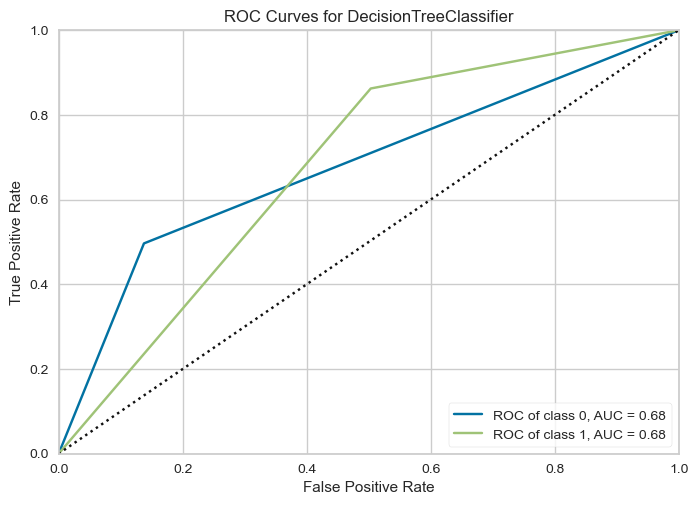

None


In [74]:
# Decision Tree Classifier with TF-IDF
tfidf_classification(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

              precision    recall  f1-score   support

           0       0.87      0.26      0.40      1033
           1       0.82      0.99      0.90      3496

    accuracy                           0.82      4529
   macro avg       0.85      0.63      0.65      4529
weighted avg       0.83      0.82      0.78      4529



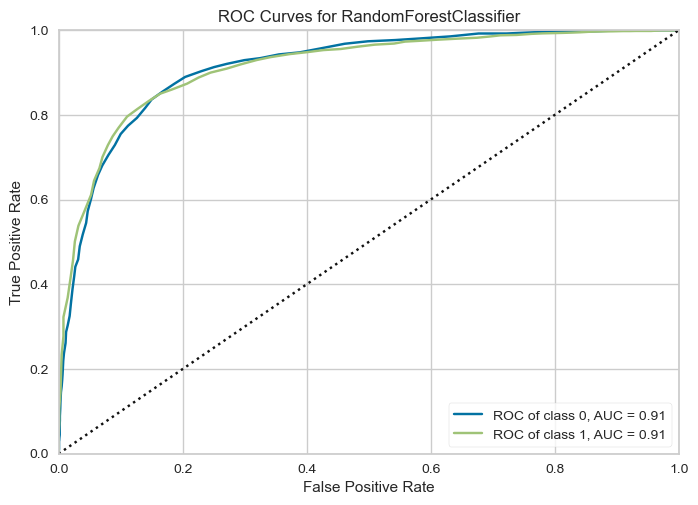

None


In [75]:
# Random Forest Classifier with TF-IDF
tfidf_classification(X_train, X_test, y_train, y_test, RandomForestClassifier())

# Sentiment Classification with Word2Vec

In [40]:
def vectorize_text(text, model):
    """
    A helper function to vectorize text using a Word2Vec model.
    :param text: 
    :param model: 
    :return: Mean vector of the words in the text
    """
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size) # zero vector if no words found

def classify_sentiment_word2vec(classifier, model):
    data[f'{model}_review_vector'] = data['review_text'].apply(lambda x: vectorize_text(x, model))

    # Split the data
    X = np.stack(data[f'{model}_review_vector'], axis=0)  # Convert list of vectors to numpy matrix
    y = data['rating_category']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model and get predictions
    clf = classifier
    clf.fit(X_train, y_train)    
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    print(plot_roc_curve(X_train, y_train, X_test, y_test, clf))

              precision    recall  f1-score   support

           0       0.45      0.46      0.45      1033
           1       0.84      0.83      0.84      3496

    accuracy                           0.75      4529
   macro avg       0.64      0.65      0.64      4529
weighted avg       0.75      0.75      0.75      4529



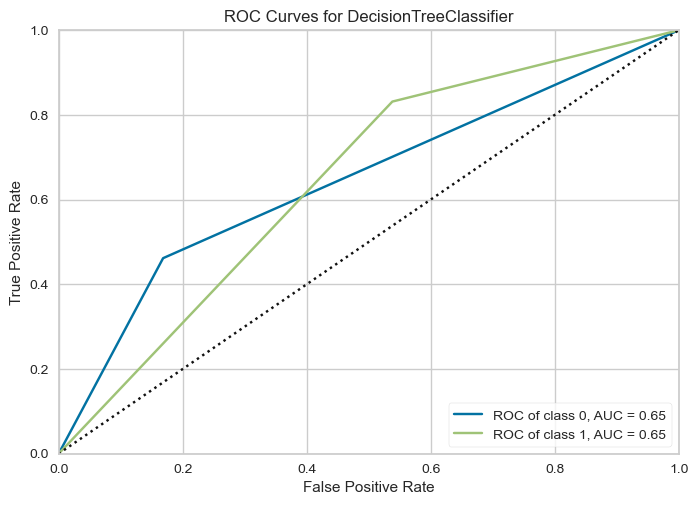

None


In [41]:
# Decision Tree Classifier with Word2Vec: Default Model
classify_sentiment_word2vec(DecisionTreeClassifier(), model_defaults)

              precision    recall  f1-score   support

           0       0.75      0.38      0.51      1033
           1       0.84      0.96      0.90      3496

    accuracy                           0.83      4529
   macro avg       0.79      0.67      0.70      4529
weighted avg       0.82      0.83      0.81      4529



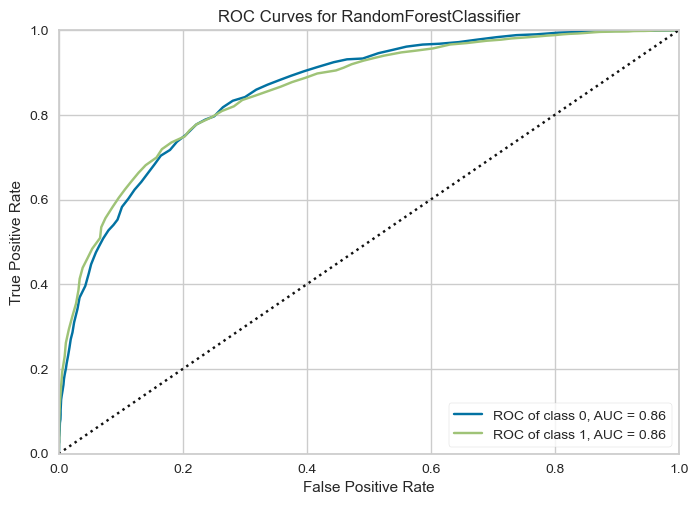

None


In [42]:
# Random Forest Classifier with Word2Vec: Default Model
classify_sentiment_word2vec(RandomForestClassifier(), model_defaults)

              precision    recall  f1-score   support

           0       0.74      0.42      0.53      1033
           1       0.85      0.96      0.90      3496

    accuracy                           0.83      4529
   macro avg       0.79      0.69      0.72      4529
weighted avg       0.82      0.83      0.82      4529



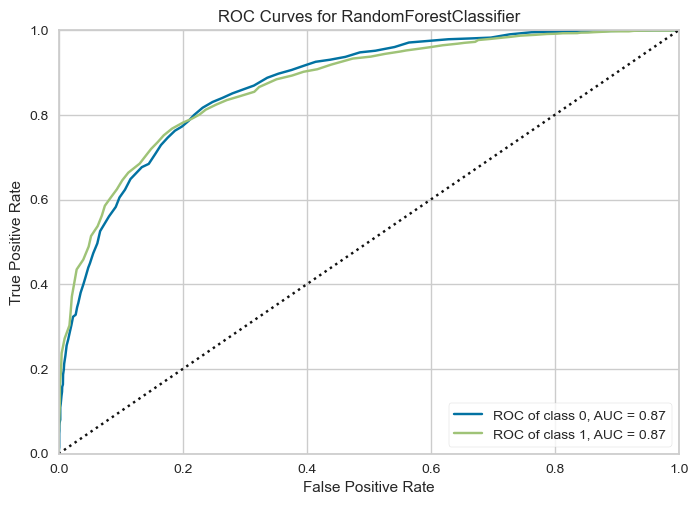

None


In [43]:
# Random Forest Classifier with Word2Vec: Tuned Model
classify_sentiment_word2vec(RandomForestClassifier(), model_tuned)

              precision    recall  f1-score   support

           0       0.78      0.40      0.53      1033
           1       0.85      0.97      0.90      3496

    accuracy                           0.84      4529
   macro avg       0.81      0.68      0.72      4529
weighted avg       0.83      0.84      0.82      4529



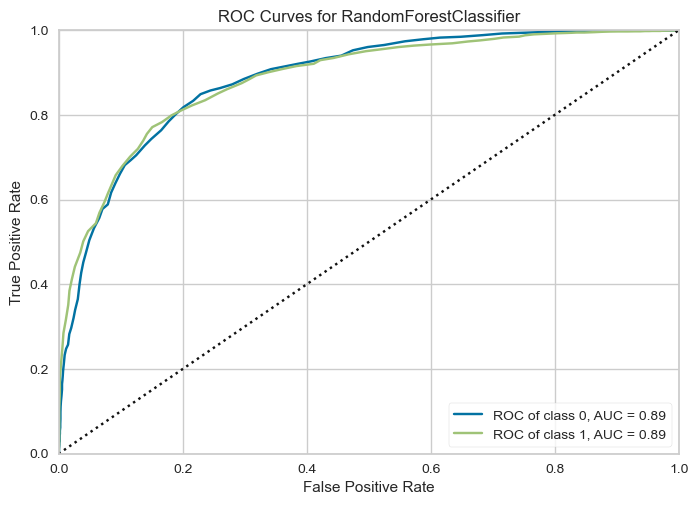

None


In [44]:
# Random Forest Classifier with Word2Vec: Tuned Model with Skip-Gram
classify_sentiment_word2vec(RandomForestClassifier(), model_tuned_sg)

              precision    recall  f1-score   support

           0       0.80      0.38      0.51      1033
           1       0.84      0.97      0.90      3496

    accuracy                           0.84      4529
   macro avg       0.82      0.68      0.71      4529
weighted avg       0.83      0.84      0.81      4529



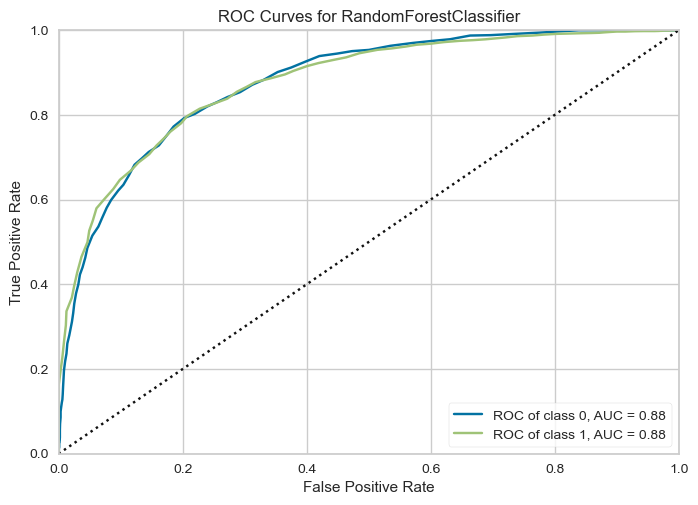

None


In [45]:
# Random Forest Classifier with Word2Vec: Tuned Model with Hierarchical Softmax
classify_sentiment_word2vec(RandomForestClassifier(), model_tuned_with_hs)

              precision    recall  f1-score   support

           0       0.75      0.41      0.53      1033
           1       0.85      0.96      0.90      3496

    accuracy                           0.83      4529
   macro avg       0.80      0.68      0.71      4529
weighted avg       0.82      0.83      0.81      4529



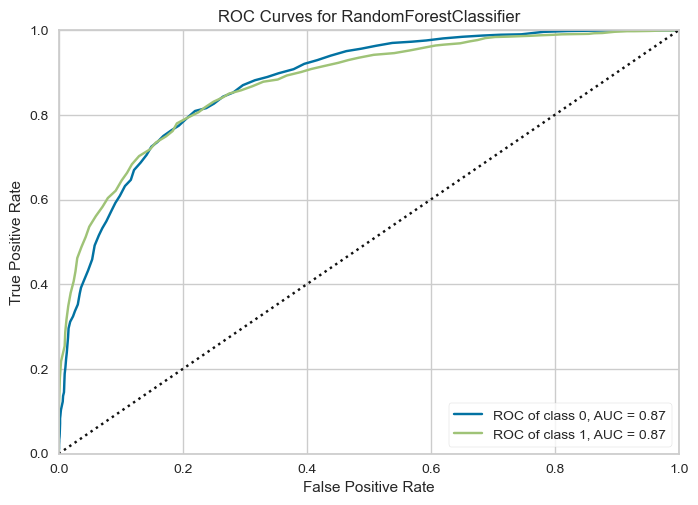

None


In [46]:
# Random Forest Classifier with Word2Vec: Tuned Model with Negative Sampling
classify_sentiment_word2vec(RandomForestClassifier(), model_tuned_with_ns)

              precision    recall  f1-score   support

           0       0.76      0.43      0.54      1033
           1       0.85      0.96      0.90      3496

    accuracy                           0.84      4529
   macro avg       0.80      0.69      0.72      4529
weighted avg       0.83      0.84      0.82      4529



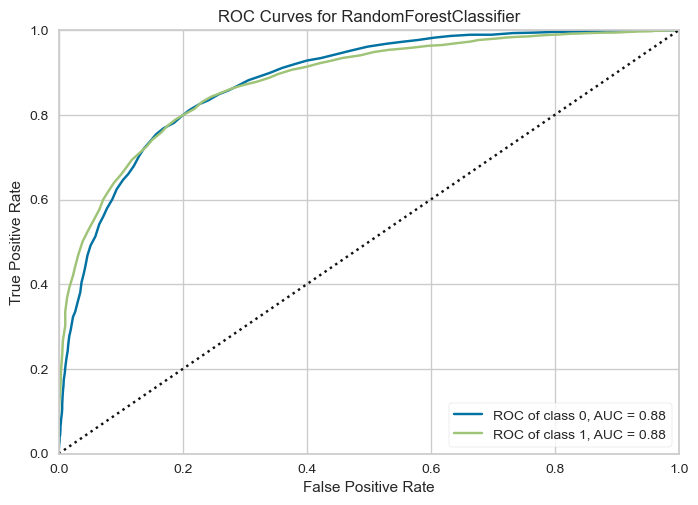

None


In [47]:
# Random Forest Classifier with Word2Vec: Tuned Model with 20 Epochs
classify_sentiment_word2vec(RandomForestClassifier(), model_tuned_20_epochs)

              precision    recall  f1-score   support

           0       0.80      0.34      0.48      1033
           1       0.83      0.98      0.90      3496

    accuracy                           0.83      4529
   macro avg       0.82      0.66      0.69      4529
weighted avg       0.83      0.83      0.80      4529



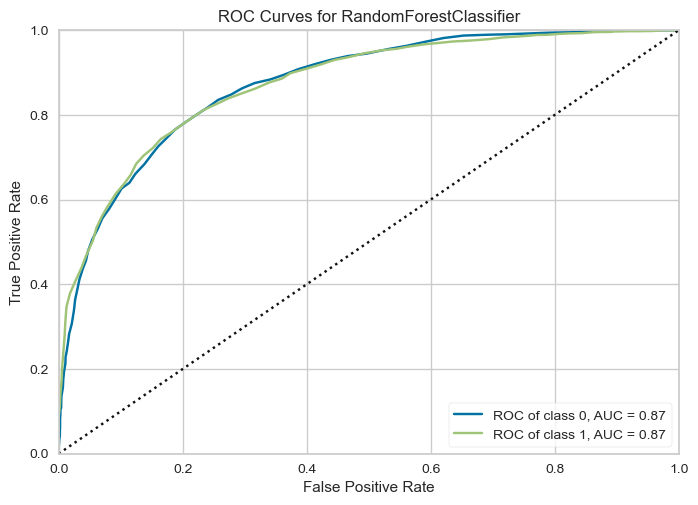

None


In [48]:
# Random Forest Classifier with Word2Vec: Tuned Model with Hierarchical Softmax and 20 Epochs
classify_sentiment_word2vec(RandomForestClassifier(), model_tuned_with_hs_20_epochs)

# Sentiment Classification with Doc2Vec

In [54]:
# Assuming 'docs' is a list of tokenized documents (list of words) from your dataset
tagged_docs = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(docs)]

# Initialize and train the Doc2Vec model
doc_model = Doc2Vec(vector_size=300, window=15, min_count=20, workers=10, epochs=10)
doc_model.build_vocab(tagged_docs)
doc_model.train(tagged_docs, total_examples=doc_model.corpus_count, epochs=doc_model.epochs)

# Prepare embeddings for the entire dataset and save as a new feature in a DataFrame
data['doc2vec_review_vector'] = [doc_model.dv[i] for i in range(len(tagged_docs))]

# Convert list of vectors to numpy matrix
X = np.array(data['doc2vec_review_vector'].tolist())
y = data['rating_category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

              precision    recall  f1-score   support

           0       0.37      0.40      0.39      1033
           1       0.82      0.80      0.81      3496

    accuracy                           0.71      4529
   macro avg       0.60      0.60      0.60      4529
weighted avg       0.72      0.71      0.71      4529



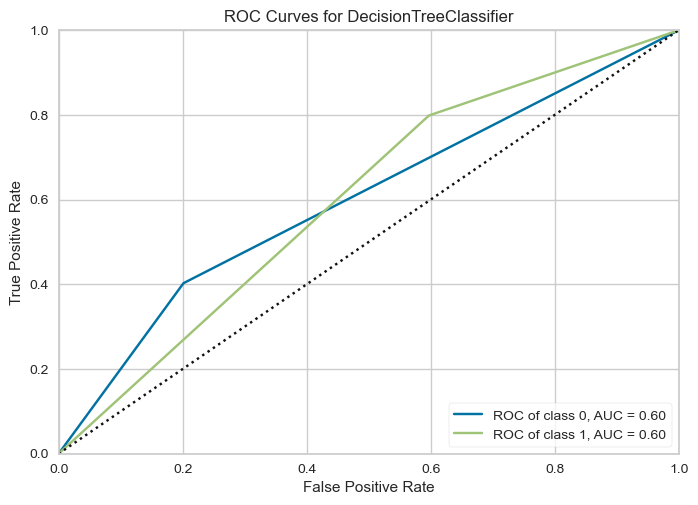

None


In [55]:
# Decision Tree Classifier with Doc2Vec
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

print(classification_report(y_test, y_pred_dt))
print(plot_roc_curve(X_train, y_train, X_test, y_test, clf_dt))

              precision    recall  f1-score   support

           0       0.78      0.21      0.33      1033
           1       0.81      0.98      0.89      3496

    accuracy                           0.81      4529
   macro avg       0.79      0.60      0.61      4529
weighted avg       0.80      0.81      0.76      4529



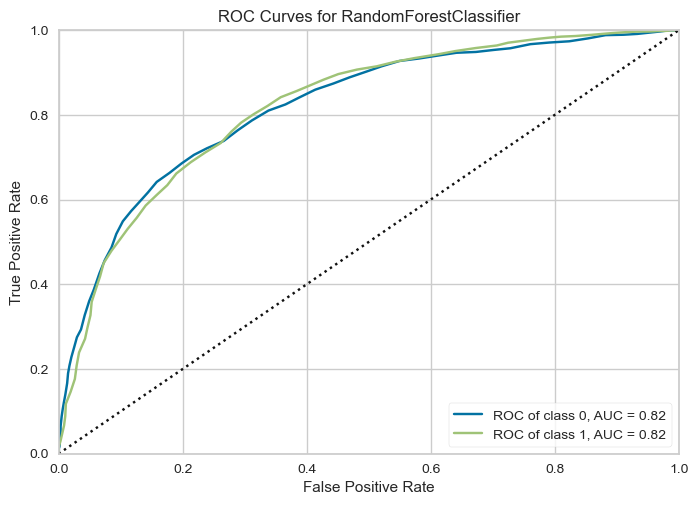

None


In [56]:
# Random Forest Classifier with Doc2Vec
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))
print(plot_roc_curve(X_train, y_train, X_test, y_test, clf_rf))

# Discussion Section:

For the Word2Vec task, we used the average of the word vectors to get a document vector, which may not always capture the relationships as well as Doc2Vec, which is designed to capture the relationships between words in a document. 

## Strengths, Weaknesses, and Limitations:

After training the Word2Vec models with different hyperparameters, the T-SNE visualization shows that the words are clustered in the 2D space. These clusters proved hard to judge visually, but the words are grouped together based on their similarity for all models. It is interesting to see how the embeddings are learned and how the relationships between words are captured in the 2D space.

I used sentiment analysis as an application of Word2Vec. I have done sentiment analysis before with N-gram models compared against a lexicon-based approach in the past, and was interested in seeing how Word2Vec would perform. In order to measure the performance of the embeddings, I trained a classifier to predict the sentiment category based on the review text. The results were somewhat surprising, as the Word2Vec models performed on par with the TF-IDF model. However, the Word2Vec models are more efficient to work with than the sparse vectors from TF-IDF.


Considering that results may be due to the fact that we are taking the mean of the word vectors to get a document vector, which may not capture the relationships as well as Doc2Vec, so we tried Doc2Vec as well. Although the results were also on par with the Word2Vec models, the Doc2Vec embeddings may be more suitable for this task, as they are designed to capture the relationships between words in a document.


Note, these results may be due to the way we are evaluating the sentiment. **We used a proxy for sentiment by categorizing the ratings as positive or negative, which may not be the best way to evaluate sentiment**.

Additionally, because we are examining reviews, the TF-IDF model may have performed better because reviews hinge on "important words", rather than the semantic relationships between words. The Word2Vec model may not be able to capture the importance of words in the same way as TF-IDF.

Additional notes:

- Word2Vec will produce a key error if the word is not in the vocabulary, see code cell below for an example. Which we need to handle if we are to use the embeddings in a real-world application.

In [52]:
# Example of key error for a word not in the vocabulary
print("Embedding for 'clutch':", model_tuned.wv['clutch'])

KeyError: "Key 'clutch' not present"

In [53]:
# The issue also occurs with Doc2Vec
print("Embedding for 'pompom':", doc_model.wv['pompom'])

KeyError: "Key 'pompom' not present"